# Introduction

Welcome to Amy, Josh, and Joe's CIS 545 project! 

The goal of this project is to compare the effectiveness of different machine learning models when it comes to detecting sarcasm in written text. The dataset we use is the Sarcasm on Reddit dataset on Kaggle (https://www.kaggle.com/datasets/danofer/sarcasm) which contains over 1 million rows of comments from various users on various subreddits. The comments are labeled as sarcastic or not sarcastic according to users' use of the /s tag when posting the comment, reddit's tag made available to users to indicate sarcasm. We will perform exploratory data analysis (EDA) on this dataset before making use of it to train several machine learning models. We compare models trained on basic text features using different algorithms, TF-IDF features, as well as more advanced BERT contextual embeddings. 

# Setup

In [ ]:
!pip install pandasql

In [ ]:
import pandas as pd
import numpy as np 
import time
import bz2
import numpy as np
import pandasql as ps 
import datetime as dt

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag

import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# This is the raw data if we need it
'''
!wget -nc https://nlp.cs.princeton.edu/SARC/0.0/main/sarc.csv.bz2 

sarc_file = bz2.open('sarc.csv.bz2', mode='rt')
raw_sarc_data_df = pd.read_table(sarc_file, delimiter = '\t', nrows=1000000, names=['label', 'comment', 'user', 'sub', 'score', 'ups', 'downs', 'date', 'time created', 'parent comment'])
raw_sarc_data_df
'''

"\n!wget -nc https://nlp.cs.princeton.edu/SARC/0.0/main/sarc.csv.bz2 \n\nsarc_file = bz2.open('sarc.csv.bz2', mode='rt')\nraw_sarc_data_df = pd.read_table(sarc_file, delimiter = '\t', nrows=1000000, names=['label', 'comment', 'user', 'sub', 'score', 'ups', 'downs', 'date', 'time created', 'parent comment'])\nraw_sarc_data_df\n"

--Upload Kaggle.json file now--

In [ ]:
# And this is the processed training/testing data from Kaggle. We will use the data in the balanced training file as our whole dataset.
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d danofer/sarcasm
! unzip /content/sarcasm.zip

 98% 212M/216M [00:01<00:00, 206MB/s]
100% 216M/216M [00:01<00:00, 183MB/s]
Archive:  /content/sarcasm.zip
  inflating: test-balanced.csv       
  inflating: test-unbalanced.csv     
  inflating: train-balanced-sarc.csv.gz  
  inflating: train-balanced-sarcasm.csv  


In [ ]:
df = pd.read_csv("train-balanced-sarcasm.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Data cleaning

In [ ]:
# Assign a random number to each user in order to allow for processing of this column while assuring anonmyity
rand_num_assign = np.random.choice(range(1, 10*df['author'].nunique()), size = df['author'].nunique(), replace=False)
rand_num_dict = dict(zip(df['author'].unique(), rand_num_assign))
df['author'] = df['author'].map(rand_num_dict)
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,1999755,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,2120735,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",98855,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",559029,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,1163345,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,912647,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",75483,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,2035016,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,2211260,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [ ]:
# Check if there are null values in the 'comment' column
df[df['comment'].isnull()]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
56269,1,NaN,135226,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a sh..."
68590,1,NaN,74104,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should p...
135348,0,NaN,1276555,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,2043394,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,1644652,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your ki..."
284331,0,NaN,415651,ar15,1,1,0,2016-05,2016-05-20 22:18:51,"Fuck you too, buddy."
312969,0,NaN,2364450,nameaserver,1,1,0,2016-08,2016-08-05 07:36:37,Thu 2016-08-04 accessing vault............unlo...
328775,1,NaN,622750,todayilearned,6,6,0,2016-08,2016-08-18 12:36:21,What symbol denotes suck?
331735,1,NaN,2263915,soccer,1,1,0,2016-06,2016-06-14 13:38:04,Doesn't matter if that experience is garbage
332600,1,NaN,2137876,leagueoflegends,-16,-16,0,2016-03,2016-03-03 12:04:43,Your favourite lol joke?


In [ ]:
df = df.dropna(axis=0, subset=['comment'])

In [ ]:
df['created_utc'] = pd.to_datetime(df.created_utc)
df.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  int64         
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 84.8+ MB


Unfortunately, we could not find in the information given with this dataset on Kaggle or in the paper describing its creation what exactly the "score", "ups", and "downs" columns refer to. We imagine they are some indicator of comment upvotes and downvotes, but the presence of negative values in these columns are seemingly nonsensical if this is the case. Therefore, we choose to ignore these columns in subsequent analyses. 

# EDA

Here we perform exploratory data analysis to investigate the features of sarcastic and non-sarcastic comments and trends over time.

In [ ]:
# Check dataset balance
sql_query1 = 'SELECT COUNT("label") AS "Occurences" FROM df GROUP BY "label"'
check_balance_df = ps.sqldf(sql_query1, locals())
check_balance_df

,Occurences
0,505405
1,505368


[Text(0, 0.5, 'Total Count'),
 Text(0.5, 0, 'Not Sarcastic (0) or Sarcastic (1)'),
 Text(0.5, 1.0, 'Distribution of Labels')]

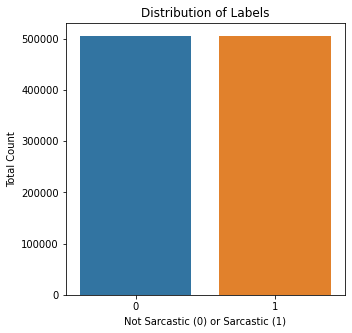

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Labels", xlabel="Not Sarcastic (0) or Sarcastic (1)", ylabel = "Total Count")

After dropping null comments, the dataset remains well-balanced. 

In [ ]:
df_sarcasm = df.loc[df['label']==1]
df_non_sarcasm = df.loc[df['label']==0]

In [ ]:
# Get comment text, ignoring stopwords using nltk

#df_sarcasm = df_sarcasm.sample(10000,replace=False,random_state=1)
df_sarcasm['comment'] = df_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in word_tokenize(x.strip(' ')) if word not in (stopwords)]))
df_sarcasm_text = df_sarcasm['comment'].tolist()
df_sarcasm_text = " ".join(df_sarcasm_text)

#df_non_sarcasm  = df_non_sarcasm.sample(10000,replace=False,random_state=1)
df_non_sarcasm['comment'] = df_non_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in word_tokenize(x.strip(' ')) if word not in (stopwords)]))
df_non_sarcasm_text = df_non_sarcasm['comment'].tolist()
df_non_sarcasm_text = " ".join(df_non_sarcasm_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Find exclamation marks in comments
def count_character_type(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            specialChar+=1
        
    return specialChar

excl_count_sarcasm = count_character_type(df_sarcasm_text)
excl_count_non = count_character_type(df_non_sarcasm_text)

print(f"Count of exclamation marks for sarcastic comments: {excl_count_sarcasm}")
print(f"Count of exclamation marks for non sarcastic comments: {excl_count_non}")

Count of exclamation marks for sarcastic comments: 69538
Count of exclamation marks for non sarcastic comments: 28147


Takeaway: There are far more exclamation marks in sarcastic comments than non-sarcastic comments.

In [ ]:
# Find question marks in comments
def count_question_mark(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "?":
            specialChar+=1
        
    return specialChar

qnmark_count_sarcasm = count_question_mark(df_sarcasm_text)
qnmark_count_non = count_question_mark(df_non_sarcasm_text)

print(f"Count of question marks for sarcastic comments: {qnmark_count_sarcasm}")
print(f"Count of question marks for non sarcastic comments: {qnmark_count_non}")

Count of question marks for sarcastic comments: 55112
Count of question marks for non sarcastic comments: 62963


Takeaway: There are slightly more question marks in sarcastic comments than non sarcasic comments

In [ ]:
# Find uppercase letters in comments
def count_upper(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch.isupper():
            specialChar+=1
        
    return specialChar

upper_count_sarcasm = count_upper(df_sarcasm_text)
upper_count_non = count_upper(df_non_sarcasm_text)

print(f"Count of uppercase letters for sarcastic comments: {upper_count_sarcasm}")
print(f"Count of uppercase letters for non sarcastic comments: {upper_count_non}")

Count of uppercase letters for sarcastic comments: 1205880
Count of uppercase letters for non sarcastic comments: 1229327


Takeaway: There are marginally more uppercase letters in sarcastic comments than non sarcastic comments, likely not enough to be significant.

In [ ]:
# Find average length of comments, splitting by whitespace
df["comment_length"] = df["comment"].str.split().str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.groupby("label")["comment_length"].mean()

label
0    10.591973
1    10.330915
Name: comment_length, dtype: float64

The average length of the comments (by word count) are also similar between sarcastic and non sarcastic groups, with non-sarcastic comments being slightly longer on average.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


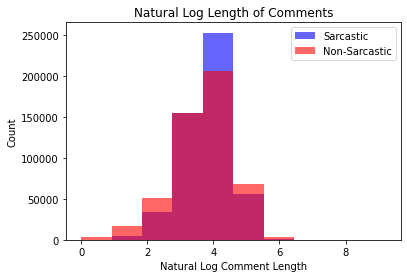

In [ ]:
# Bin comment length
import math
df['log_comment'] = df['comment'].apply(lambda text: math.log(len(str(text))))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue', grid=False)
df[df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red', grid=False)
plt.legend()
nlcax = plt.axes()
nlcax.set(title='Natural Log Length of Comments', xlabel='Natural Log Comment Length', ylabel='Count')
plt.show()

Takeaway: Sarcastic comments are slightly more concentrated in the length of the comments. Both skew left with more longer than average comments (> ~60 characters) and shorter than average comments (< ~20 characters) among non-sarcastic comments. This could reveal that may be an "optimum" length for communicating sarcasm. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


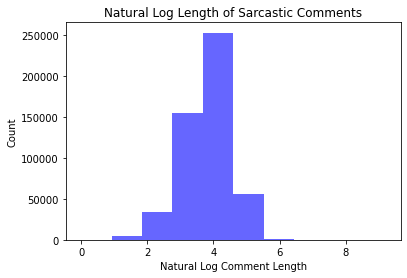

In [ ]:
import math
df['log_comment'] = df['comment'].apply(lambda text: math.log(len(str(text))))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue', grid=False)
nlcax1 = plt.axes()
nlcax1.set(title='Natural Log Length of Sarcastic Comments', xlabel='Natural Log Comment Length', ylabel='Count')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


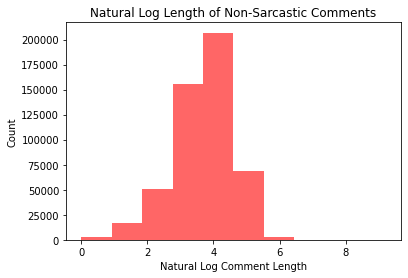

In [ ]:
import math
df['log_comment'] = df['comment'].apply(lambda text: math.log(len(str(text))))
df[df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red', grid=False)
nlcax0 = plt.axes()
nlcax0.set(title='Natural Log Length of Non-Sarcastic Comments', xlabel='Natural Log Comment Length', ylabel='Count')
plt.show()

In [ ]:
# Find percentage of sarcastic and non-sarcastic comments by day of the week

df['created_utc'] = pd.to_datetime(df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
df['day_of_week'] = df['created_utc'].dt.day_name()
# df.info()
label_df = df.groupby(['day_of_week', 'label'])["comment"].count().reset_index(name='count')
sum_df = df.groupby(['day_of_week'])["comment"].count().reset_index(name='total_count')
merge_df = label_df.merge(sum_df, on ='day_of_week', how = 'left')
merge_df['percentage'] = merge_df['count']/ merge_df['total_count']
merge_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,day_of_week,label,count,total_count,percentage
0,Friday,0,75060,149826,0.500981
1,Friday,1,74766,149826,0.499019
2,Monday,0,72931,146382,0.498224
3,Monday,1,73451,146382,0.501776
4,Saturday,0,62598,122624,0.510487
5,Saturday,1,60026,122624,0.489513
6,Sunday,0,64060,126497,0.506415
7,Sunday,1,62437,126497,0.493585
8,Thursday,0,77156,155422,0.496429
9,Thursday,1,78266,155422,0.503571


Takeaway: The level of sarcasm doesn't differ overtly by day of week.

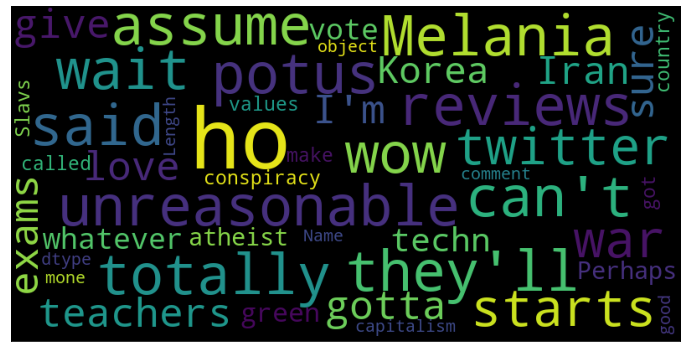

In [ ]:
# Create wordcloud visualizations of most common words in sarcastic and non-sarcastic comments 

wordcloud = WordCloud(background_color='black', stopwords = stopwords,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wcax1 = plt.axes()
wcax1.get_xaxis().set_visible(False)
wcax1.get_yaxis().set_visible(False)
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

Takeaway: Political words such as Melania, Korea, potus, Iran, vote make more appearances alongside some concerning words such as slaves, war, ho, and conspiracy.

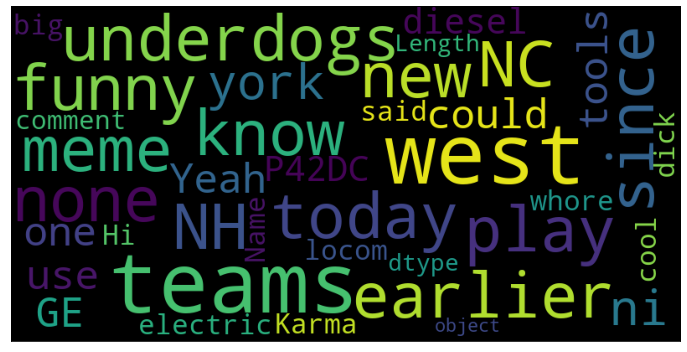

In [ ]:
wordcloud = WordCloud(background_color='black', stopwords = stopwords,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wcax0 = plt.axes()
wcax0.get_xaxis().set_visible(False)
wcax0.get_yaxis().set_visible(False)
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

Takeaway: No strong political undertone is present in the word cloud for non sarcastic comments

In [ ]:
# Find number of sarcastic comments per user

sql_query2 = 'SELECT "author", COUNT("comment") AS "Num" FROM df WHERE "label"=1 GROUP BY "author"'
user_comments_df1 = ps.sqldf(sql_query2, locals())
user_comments_df1

,author,Num
0,1,1
1,20,1
2,27,1
3,39,3
4,40,3
...,...,...
256396,2565560,1
256397,2565573,1
256398,2565581,1
256399,2565585,1


In [ ]:
print(user_comments_df1['Num'].mean())
print(user_comments_df1['Num'].std())

1.9710063533293551
3.0223584805336934


[Text(0, 0.5, 'Count (Users)'),
 Text(0.5, 0, 'Number of Comments'),
 Text(0.5, 1.0, 'Number of Sarcastic Comments From Users')]

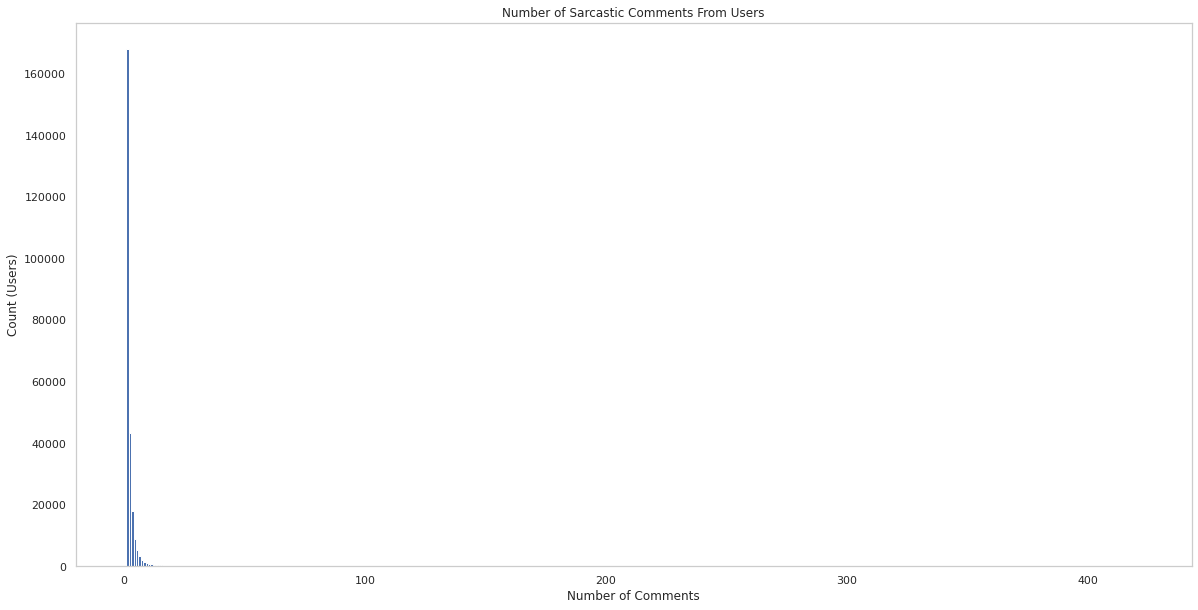

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
NumSarcAx = plt.axes()
user_comments_df1.hist(column='Num', grid=False, bins=user_comments_df1['Num'].max(), ax=NumSarcAx)
NumSarcAx.set(title="Number of Sarcastic Comments From Users", xlabel="Number of Comments", ylabel="Count (Users)")

The average user only produces about 2 sarcastic comments, with a large standard deviation coming from the few users who produce hundreds of comments.

A more informative metric may be the ratio of sarcastic to non-sarcastic comments made by each user, but the original dataset was created by sampling equivalent numbers of sarcastic and non-sarcasic comments, as proven below. Therefore, the above histogram is as informative as possible with the given dataset.

In [ ]:
# Find number of non-sarcastic comments per user and the ratio

sql_query3 = 'SELECT "author", COUNT("comment") AS "Num" FROM df WHERE "label"=0 GROUP BY "author"'
user_comments_df2 = ps.sqldf(sql_query3, locals())
user_comments_df = pd.merge(user_comments_df1, user_comments_df2, on='author', suffixes=('Sarc', 'NonSarc'))
user_comments_df['Ratio'] = user_comments_df['NumSarc']/user_comments_df['NumNonSarc']
user_comments_df

,author,NumSarc,NumNonSarc,Ratio
0,1,1,1,1.0
1,20,1,1,1.0
2,27,1,1,1.0
3,39,3,3,1.0
4,40,3,3,1.0
...,...,...,...,...
254093,2565560,1,1,1.0
254094,2565573,1,1,1.0
254095,2565581,1,1,1.0
254096,2565585,1,1,1.0


In [ ]:
print(user_comments_df['Ratio'].mean())
print(user_comments_df['Ratio'].std())

0.9974373486625099
0.035857935260107006


Almost all users have sarcastic/non-sarcastic comment ratio of 1, with the slight variation coming from the dropped null comments.

In [ ]:
# Number of sarcastic comments per month per year
import datetime as dt
df['Month'] = df['created_utc'].apply(lambda x: x.strftime('%m'))
df['Year'] = df['created_utc'].apply(lambda x: x.strftime('%Y'))
df['Year-Month'] = df['created_utc'].apply(lambda x: x.strftime('%Y-%m'))
sql_query4 = 'SELECT "Year", "Month", "Year-Month", "label" FROM df ORDER BY "Year", "Month"'
comments_over_time_df = ps.sqldf(sql_query4, locals())
comments_over_time_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Year,Month,Year-Month,label
0,2009,01,2009-01,0
1,2009,01,2009-01,1
2,2009,01,2009-01,0
3,2009,01,2009-01,0
4,2009,01,2009-01,0
...,...,...,...,...
1010768,2016,12,2016-12,1
1010769,2016,12,2016-12,0
1010770,2016,12,2016-12,0
1010771,2016,12,2016-12,0


[Text(0.5, 1.0, 'Number of Sarcastic (label 1) and Non-Sarcastic (label 0) Comments from Users by Month')]

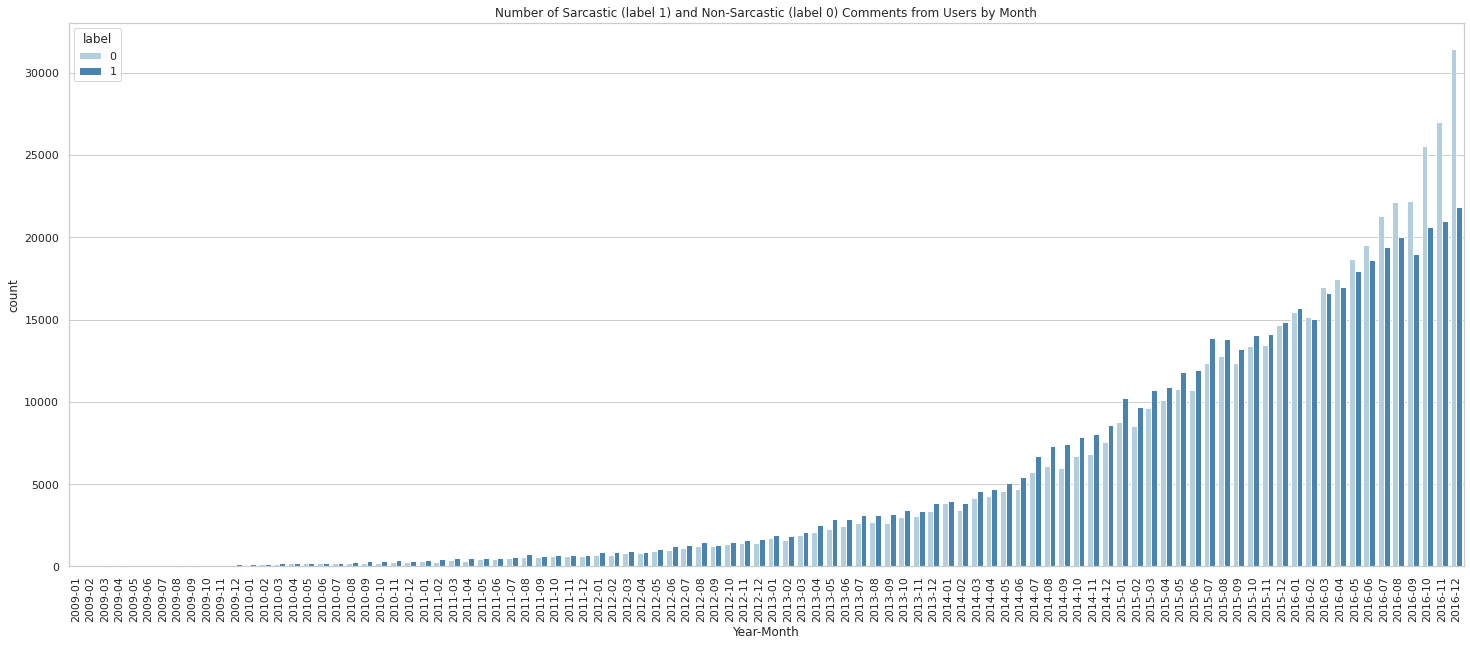

In [ ]:
sns.set(rc = {'figure.figsize':(25,10)})
sns.set_theme(style="whitegrid")
per_month_ax = sns.countplot(x='Year-Month', hue='label', data=comments_over_time_df, palette='Blues')
per_month_ax.tick_params(axis='x', rotation=90)
per_month_ax.set(title="Number of Sarcastic (label 1) and Non-Sarcastic (label 0) Comments from Users by Month")

It is interesting to note how the number of comments added to the dataset over time steadily increases, but only in the most recent months does the number of non-sarcastic comments exceed the number of sarcastic comments. Overall, the ratio of non-sarcastic to sarcastic comments was chosen to be 1 for all users as proven above, so this would seem to indicate that most users are posting  more non-sarcastic comments in the most recent months of the dataset relative to prior months and years. 

We can show this more directly by looking at the average ratio of sarcastic to non-sarcastic comments for users over time. 

In [ ]:
# Find the average percentage of sarcastic comments per user for each year
avg_perc = []
std_perc = []
for year in range(2009, 2017):
  sql_query5 = 'SELECT "author", "Year", COUNT("comment") AS "Num" FROM df WHERE "label"=1 AND "Year"=' + str(year) + ' GROUP BY "author", "Year"'
  sarc_over_time_df1 = ps.sqldf(sql_query5, locals())
  sql_query6 = 'SELECT "author", "Year", COUNT("comment") AS "Num" FROM df WHERE "label"=0 AND "Year"=' + str(year) + ' GROUP BY "author", "Year"'
  sarc_over_time_df2 = ps.sqldf(sql_query6, locals())
  sarc_over_time_df = pd.merge(sarc_over_time_df1, sarc_over_time_df2, how='outer', on=['author', 'Year'], suffixes=('Sarc', 'NonSarc'))
  sarc_over_time_df = sarc_over_time_df.fillna(value=0)
  sarc_over_time_df['PercentageSarcastic'] = 100*(sarc_over_time_df['NumSarc']/(sarc_over_time_df['NumSarc'] + sarc_over_time_df['NumNonSarc']))
  avg_perc.append(sarc_over_time_df['PercentageSarcastic'].mean())
  std_perc.append(sarc_over_time_df['PercentageSarcastic'].std())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Percentage of Sarcastic Comments from Users Over Time')

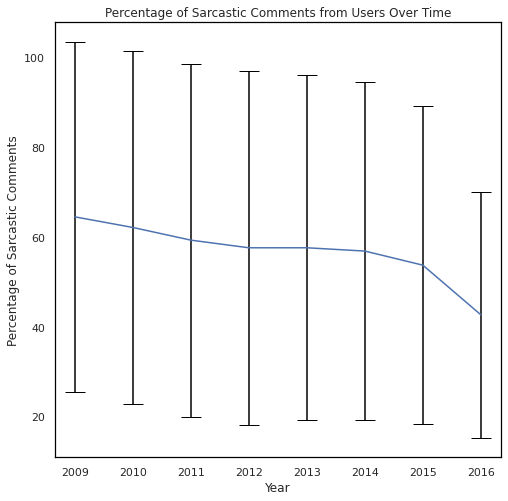

In [ ]:
sns.set(rc = {'figure.figsize':(8, 8)})
plt.errorbar(x=range(2009, 2017), y=avg_perc, yerr=std_perc, ecolor='black', capsize=10)
perc_sarc_ax = plt.axes()
perc_sarc_ax.set_facecolor("white")
perc_sarc_ax.spines["left"].set_color("black")
perc_sarc_ax.spines["bottom"].set_color("black")
perc_sarc_ax.spines["right"].set_color("black")
perc_sarc_ax.spines["top"].set_color("black")
plt.xlabel("Year")
plt.ylabel("Percentage of Sarcastic Comments")
plt.title("Percentage of Sarcastic Comments from Users Over Time")

Obviously, this analysis is lacking because with this dataset we do not know all of the comments posted by every user but rather a limited balanced selection. Nevertheless, the data available suggests that, on average, the percentage of sarcastic comments made by any given user decreases over time.

# Logistic Regression With Extracted Features

In this section we will attempt basic logistic regression to predict whether a comment is sarcastic or not. We will base this modeling on basic features extracted from the text of the comment as well as the parent comment, such as comment length, punctuation, number of fully capitalized words, etc... 

Here we re-initialize the dataframe so that this section could be run separately from the above EDA.

In [ ]:
# Read in data fresh for modeling 
sarc_data_df = pd.read_csv("train-balanced-sarcasm.csv")

In [ ]:
# Drop rows with null comments
sarc_data_df = sarc_data_df.dropna(axis=0, subset=['comment'])

In [ ]:
# Assign a random number to each user in order to allow for processing of this column while assuring anonmyity
rand_num_assign = np.random.choice(range(1, 10*sarc_data_df['author'].nunique()), size = sarc_data_df['author'].nunique(), replace=False)
rand_num_dict = dict(zip(sarc_data_df['author'].unique(), rand_num_assign))
sarc_data_df['author'] = sarc_data_df['author'].map(rand_num_dict)
sarc_data_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [ ]:
# Downsample for testing purposes, final analysis will be run on full ~1mil rows
'''
sarc_data_df = sarc_data_df.sample(n=50000, replace=False)
'''

Before considering any contextual embeddings or in-depth algorithms like BERT, we examine in this section whether we can build a model with reasonable accuracy trained on simple features extracted from the text of the comments.

In [ ]:
# First, create a new dataframe where we can store just those features extracted from the comments without all the other information available in the original data.
extracted_features_df = sarc_data_df
extracted_features_df['comment'] = extracted_features_df['comment'].apply(lambda x: str(x).strip(' '))
extracted_features_df['parent_comment'] = extracted_features_df['parent_comment'].apply(lambda x: str(x).strip(' '))
extracted_features_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [ ]:
# Extract features

# Extract number of sentences
extracted_features_df['SentenceCount'] = extracted_features_df['comment'].apply(lambda x: len(sent_tokenize(x)))

# Extract number of words
extracted_features_df['WordCount'] = extracted_features_df['comment'].apply(lambda x: len([word for word in word_tokenize(x) if word not in stopwords and str(word).isalpha()]))

extracted_features_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,SentenceCount,WordCount
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",1,2
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,1,10
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,1,12
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,1,8
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,...",1,8
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...,1,3
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...,1,7
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...,1,6


In [ ]:
# Extract number of specific types of punctuation and capital letters
import re

def NumExclamation(phrase):
  value = 0
  for char in str(phrase):
    if char =='!':
      value = value + 1
  return value
def NumQuestion(phrase):
  value = 0
  for char in str(phrase):
    if char =='?':
      value = value + 1
  return value
def NumQuote(phrase):
  value = 0
  for char in str(phrase):
    if char =='"' or char == '\'':
      value = value + 1
  return value
def NumEllipses(phrase):
  value1 = len(re.findall('\.\.\.', phrase))
  value2 = len(re.findall('\.\.', phrase))
  return value1 + value2
def NumCapital(phrase):
  value = 0
  for char in str(phrase):
    if char.isupper():
      value = value + 1
  return value
def NumFullyCapital(phrase):
  value = 0
  words = [word for word in word_tokenize(phrase) if str(word).isalpha()]
  for word in words:
    cap = True
    for char in word:
      if char.islower():
        cap = False
    if cap:
      value = value + 1
  return value

extracted_features_df['NumExclamation'] = extracted_features_df['comment'].apply(lambda x: NumExclamation(x))
extracted_features_df['NumQuestion'] = extracted_features_df['comment'].apply(lambda x: NumQuestion(x))
extracted_features_df['NumQuote'] = extracted_features_df['comment'].apply(lambda x: NumQuote(x))
extracted_features_df['NumEllipses'] = extracted_features_df['comment'].apply(lambda x: NumEllipses(x))
extracted_features_df['NumCapital'] = extracted_features_df['comment'].apply(lambda x: NumCapital(x))
extracted_features_df['NumFullyCapital'] = extracted_features_df['comment'].apply(lambda x: NumFullyCapital(x))
extracted_features_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,SentenceCount,WordCount,NumExclamation,NumQuestion,NumQuote,NumEllipses,NumCapital,NumFullyCapital
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",1,2,0,0,0,0,4,2
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,1,10,0,1,0,0,1,0
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,1,12,0,0,1,0,3,0
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,1,8,0,0,3,0,1,0
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,1,5,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,...",1,8,0,0,1,0,4,1
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...,1,3,1,0,1,0,0,0
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...,1,7,0,1,0,0,2,0
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...,1,6,0,0,0,0,3,0


In [ ]:
# Extract parts of speech
def FindPOS(phrase):
  words = word_tokenize(phrase)
  taggedwords = pos_tag(words)
  return taggedwords
def NumNoun(lst):
  nnnum = 0
  for tag in lst:
    if 'NN' in tag[1]:
      nnnum = nnnum + 1
  return nnnum
def NumAdj(lst):
  jjnum = 0
  for tag in lst:
    if 'JJ' in tag[1]:
      jjnum = jjnum + 1
  return jjnum
def NumVerb(lst):
  vbnum = 0
  for tag in lst:
    if 'VB' in tag[1]:
      vbnum = vbnum + 1
  return vbnum
def NumAdv(lst):
  rbnum = 0
  for tag in lst:
    if 'RB' in tag[1]:
      rbnum = rbnum + 1
  return rbnum

extracted_features_df['POSlist'] = extracted_features_df['comment'].apply(lambda x: FindPOS(x))
extracted_features_df['NumAdjective'] = extracted_features_df['POSlist'].apply(lambda x: NumAdj(x))
extracted_features_df['NumVerb'] = extracted_features_df['POSlist'].apply(lambda x: NumVerb(x))
extracted_features_df['NumAdverb'] = extracted_features_df['POSlist'].apply(lambda x: NumAdv(x))
extracted_features_df['NumNoun'] = extracted_features_df['POSlist'].apply(lambda x: NumNoun(x))
extracted_features_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,...,NumQuestion,NumQuote,NumEllipses,NumCapital,NumFullyCapital,POSlist,NumAdjective,NumVerb,NumAdverb,NumNoun
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",...,0,0,0,4,2,"[(NC, NNP), (and, CC), (NH, NNP), (., .)]",0,0,0,2
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,...,1,0,0,1,0,"[(You, PRP), (do, VBP), (know, VB), (west, JJS...",3,3,2,3
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,...,0,1,0,3,0,"[(They, PRP), (were, VBD), (underdogs, NNS), (...",0,4,1,8
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,...,0,3,0,1,0,"[(This, DT), (meme, NN), (is, VBZ), (n't, RB),...",2,2,1,5
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,...,0,0,0,1,1,"[(I, PRP), (could, MD), (use, VB), (one, CD), ...",0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,...",...,0,1,0,4,1,"[(I, PRP), ('m, VBP), (sure, JJ), (that, IN), ...",3,3,0,5
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...,...,0,1,0,0,0,"[(whatever, WDT), (you, PRP), (do, VBP), (,, ,...",1,3,1,0
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...,...,1,0,0,2,0,"[(Perhaps, RB), (this, DT), (is, VBZ), (an, DT...",2,3,1,2
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...,...,0,0,0,3,0,"[(The, DT), (Slavs, NNP), (got, VBD), (their, ...",1,3,0,3


In [ ]:
# Create feature and target dataframes for regression
features_df = extracted_features_df.drop(columns=['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'POSlist'])
labels_df = extracted_features_df['label']

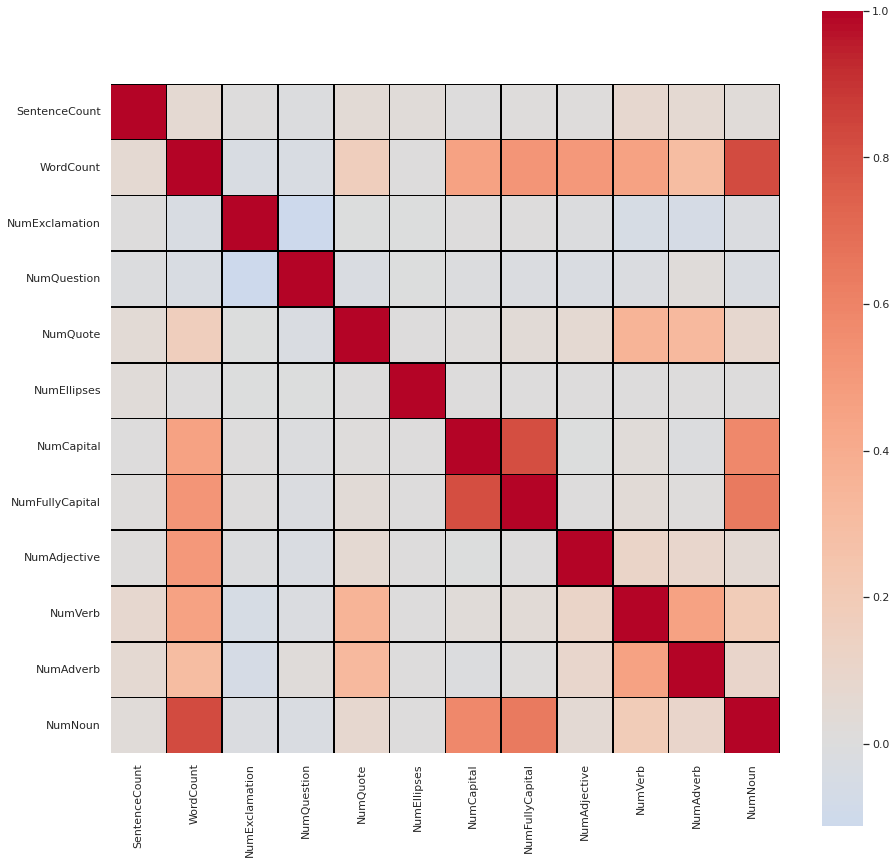

In [ ]:
features_corr_mat = features_df.corr()
sns.set(rc = {'figure.figsize':(15,15)})
heat1ax = sns.heatmap(features_corr_mat, center=0, cmap='coolwarm', square=True, linecolor='black', linewidth=0.5)

The correlation heatmap reveals there is some colinearity present in the chosen features, which is to be expected. For example, the number of words that are fully capitalized obviously correlates with the total number of capital letters in a comment. However, we chose to include these features because from a logical standpoint, they may all contain information about intent and meaning within a comment, and so could be indicators of sarcasm. Techniques such as PCA and regularization could help deal with colinearity later. 

In [ ]:
# test-train split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size = 0.20, random_state = 100)

In [ ]:
# Do simple logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Since we are working with a large dataset, we will scale the data and use the saga solver with high tolerance for faster convergence
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_trans = scaler.transform(x_test)

logr = LogisticRegression(solver='saga', max_iter=100, tol=1e-2, penalty='none', random_state=42)
logr.fit(x_train_scaled, y_train)
logr.predict(x_test_trans)
train_accuracy = logr.score(x_train_scaled, y_train)
test_accuracy = logr.score(x_test_trans, y_test)
print('Training Accuracy: ' + str(train_accuracy))
print('Test Accuracy: ' + str(test_accuracy))

Training Accuracy: 0.5385027293480976
Test Accuracy: 0.5373005861838688


This simple regression gets at most ~55% accuracy, which is only marginally better than taking a 50/50 guess. As expected, training on basic features extracted from the text is not enough to create a model which achieves good accuracy at detecting sarcasm. Nevertheless, we will incorporate PCA and regularization to see if this model can be improved. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


Text(0.5, 1.0, 'PCA for Features From Comments')

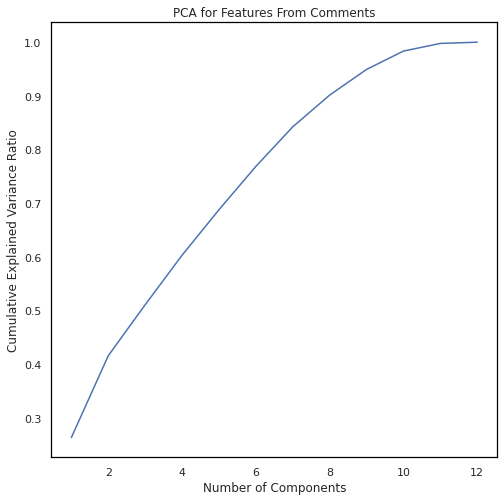

In [ ]:
# Utilize PCA and Regularization to see if the model can be improved
from sklearn.decomposition import PCA

# Try PCA
pca = PCA(n_components=12)
pca.fit_transform(x_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

# Plot results
sns.set(rc = {'figure.figsize':(8, 8)})
plt.plot(range(1, 13), cum_evr)
pca_ax = plt.axes()
pca_ax.set_facecolor("white")
pca_ax.spines["left"].set_color("black")
pca_ax.spines["bottom"].set_color("black")
pca_ax.spines["right"].set_color("black")
pca_ax.spines["top"].set_color("black")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA for Features From Comments")

According to these results, the dimensionality can be reduced by 1 dimension since increasing the number of components from 11 to 12 increases the cumulative explained variance by very little. 

In [ ]:
# Redo PCA with 1 less dimension and try the regression with this data instead
pca = PCA(n_components=11) 
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_trans)

logr = LogisticRegression(solver='saga', max_iter=500, tol=1e-2, penalty='none', random_state=42)
logr.fit(x_train_pca, y_train)
logr.predict(x_test_pca)
train_accuracy = logr.score(x_train_pca, y_train)
test_accuracy = logr.score(x_test_pca, y_test)
print('Training Accuracy: ' + str(train_accuracy))
print('Test Accuracy: ' + str(test_accuracy))

Training Accuracy: 0.5389578268106819
Test Accuracy: 0.5381068981721946


In [ ]:
# Now try some regularization in addition to PCA 

# Function which takes a list of regularization strengths and returns the model's accuracy when using those values
def logrWithReg(pvalues, cvalues):
  train_accuracies = []
  test_accuracies = []
  for pval in pvalues:
    for cval in cvalues:
      logr = LogisticRegression(solver='saga', max_iter=100, penalty='elasticnet', tol=1e-2, l1_ratio=pval, C=cval)
      logr.fit(x_train_pca, y_train)
      logr.predict(x_test_pca)
      train_acc = logr.score(x_train_pca, y_train)
      test_acc = logr.score(x_test_pca, y_test)
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)
      print('Accuracies for model with elasticnet param = ' + str(pval) + ', l1 strength = ' + str(cval) + ':')
      print('Training: ' + str(train_acc))
      print('Testing: '  +str(test_acc))
  return train_accuracies, test_accuracies

regStrength = [0.01, 0.1, 0.3, 0.6, 0.9, 0.99]
elasticStrength = [0.01, 0.1, 0.3, 0.6, 0.9, 0.99]
regModTrainAcc, regModTestAcc = logrWithReg(elasticStrength, regStrength)

Accuracies for model with elasticnet param = 0.01, l1 strength = 0.01:
Training: 0.538955353454907
Testing: 0.5381266849694541
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.1:
Training: 0.538955353454907
Testing: 0.5381118448715095
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.3:
Training: 0.5389504067433571
Testing: 0.5380821646756202
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.6:
Training: 0.5389739036232188
Testing: 0.5381464717667137
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.9:
Training: 0.538955353454907
Testing: 0.5380970047735648
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.99:
Training: 0.5389504067433571
Testing: 0.5380821646756202
Accuracies for model with elasticnet param = 0.1, l1 strength = 0.01:
Training: 0.538914543084621
Testing: 0.5380722712769904
Accuracies for model with elasticnet param = 0.1, l1 strength = 0.1:
Training: 0.5389837970463185
Testing: 0.5381

These results reveal that even with PCA and tuning of regularization parameters, accuracy only improves by a fraction of a percent at most. The best results, in terms of test accuracy, are for PCA and regularization where the elasticnet parameter = 0.6 and the regularization strength also = 0.6, which gives training accuracy 0.53902 and testing accuracy 0.53825. These consistently low accuracies reveal the model suffers from underfitting, likely because the extracted features do not contain enough information to enable meaningful predictions. 

One thing we can try with this model is training on similar features extracted from both comments and their parent comments, as that information is included in the original dataset as well. 

In [ ]:
# Create the same features based on the parent comment
extracted_features_df['ParSentenceCount'] = extracted_features_df['parent_comment'].apply(lambda x: len(sent_tokenize(x)))
extracted_features_df['ParWordCount'] = extracted_features_df['parent_comment'].apply(lambda x: len([word for word in word_tokenize(x) if word not in stopwords and str(word).isalpha()]))
extracted_features_df['ParNumExclamation'] = extracted_features_df['parent_comment'].apply(lambda x: NumExclamation(x))
extracted_features_df['ParNumQuestion'] = extracted_features_df['parent_comment'].apply(lambda x: NumQuestion(x))
extracted_features_df['ParNumQuote'] = extracted_features_df['parent_comment'].apply(lambda x: NumQuote(x))
extracted_features_df['ParNumEllipses'] = extracted_features_df['parent_comment'].apply(lambda x: NumEllipses(x))
extracted_features_df['ParNumCapital'] = extracted_features_df['parent_comment'].apply(lambda x: NumCapital(x))
extracted_features_df['ParNumFullyCapital'] = extracted_features_df['parent_comment'].apply(lambda x: NumFullyCapital(x))

In [ ]:
def FindPOSFull(phrase):
  words = word_tokenize(phrase)
  taggedwords = pos_tag(words)
  nnnum = 0
  vbnum = 0
  jjnum = 0
  rbnum = 0
  for tag in taggedwords:
    if 'NN' in tag[1]:
      nnnum = nnnum + 1
    if 'VB' in tag[1]:
      vbnum = vbnum + 1
    if 'JJ' in tag[1]:
      jjnum = jjnum + 1
    if 'RB' in tag[1]:
      rbnum = rbnum + 1
  return (nnnum, vbnum, jjnum, rbnum)

extracted_features_df['ParNumAdjective'] = extracted_features_df['parent_comment'].apply(lambda x: FindPOSFull(x)[2])
extracted_features_df['ParNumVerb'] = extracted_features_df['parent_comment'].apply(lambda x: FindPOSFull(x)[1])
extracted_features_df['ParNumAdverb'] = extracted_features_df['parent_comment'].apply(lambda x: FindPOSFull(x)[3])
extracted_features_df['ParNumNoun'] = extracted_features_df['parent_comment'].apply(lambda x: FindPOSFull(x)[0])
extracted_features_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,...,ParNumExclamation,ParNumQuestion,ParNumQuote,ParNumEllipses,ParNumCapital,ParNumFullyCapital,ParNumAdjective,ParNumVerb,ParNumAdverb,ParNumNoun
0,0,NC and NH.,2072040,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",...,0,0,1,0,6,3,0,4,2,3
1,0,You do know west teams play against west teams...,1884524,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,...,0,0,0,0,3,0,2,3,3,8
2,0,"They were underdogs earlier today, but since G...",1224935,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,...,0,0,1,0,1,0,0,3,0,0
3,0,"This meme isn't funny none of the ""new york ni...",1593690,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,...,0,0,1,0,0,0,0,2,1,2
4,0,I could use one of those tools.,577935,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,...,0,0,0,0,9,1,0,5,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,1560809,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,...",...,0,0,0,0,1,0,3,6,1,8
1010822,1,"whatever you do, don't vote green!",1037001,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...,...,0,0,0,0,6,1,3,2,0,11
1010823,1,Perhaps this is an atheist conspiracy to make ...,1641271,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...,...,0,0,1,0,5,1,0,4,0,3
1010824,1,The Slavs got their own country - it is called...,1942893,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...,...,0,1,1,0,6,2,3,11,1,8


In [ ]:
# Use all features now
full_features_df = extracted_features_df.drop(columns=['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'POSlist'])
full_labels_df = extracted_features_df['label']

full_x_train, full_x_test, full_y_train, full_y_test = train_test_split(full_features_df, full_labels_df, test_size = 0.20, random_state = 100)

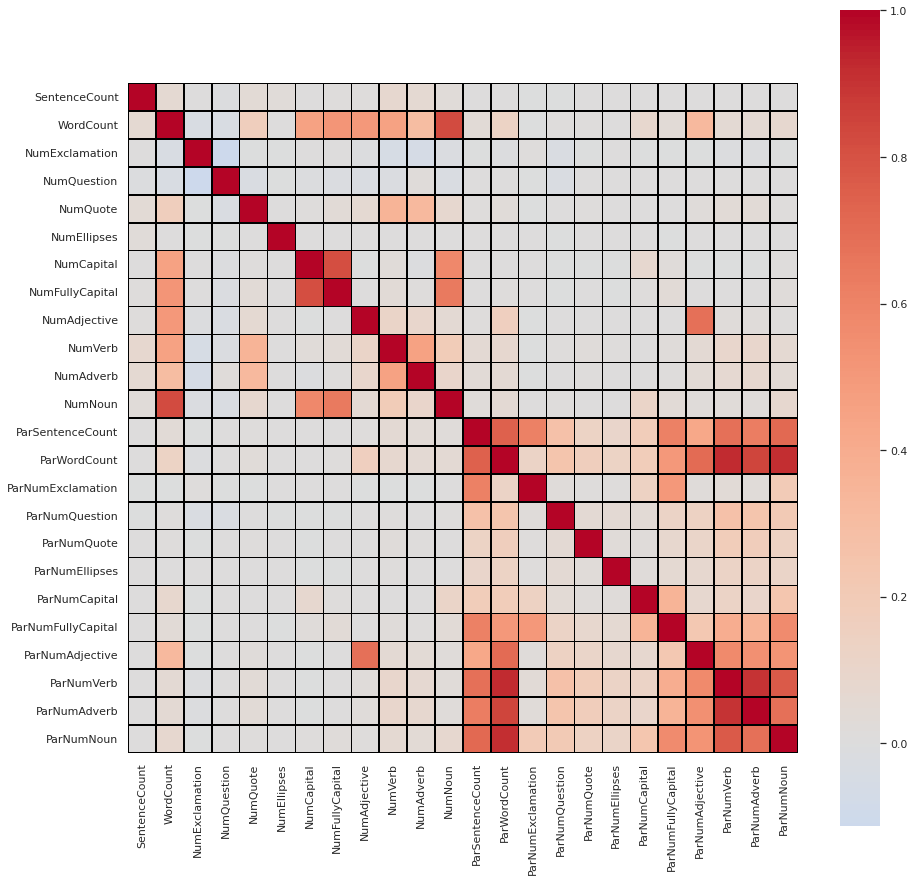

In [ ]:
full_features_corr_mat = full_features_df.corr()
sns.set(rc = {'figure.figsize':(15,15)})
heat1ax = sns.heatmap(full_features_corr_mat, center=0, cmap='coolwarm', square=True, linecolor='black', linewidth=0.5)

In [ ]:
# Simple logistic regression using all features
scaler = StandardScaler()
full_x_train_scaled = scaler.fit_transform(full_x_train)
full_x_test_trans = scaler.transform(full_x_test)

logr = LogisticRegression(solver='saga', max_iter=100, tol=1e-2, penalty='none', random_state=42)
logr.fit(full_x_train_scaled, full_y_train)
logr.predict(full_x_test_trans)
train_accuracy = logr.score(full_x_train_scaled, full_y_train)
test_accuracy = logr.score(full_x_test_trans, full_y_test)
print('Training Accuracy: ' + str(train_accuracy))
print('Test Accuracy: ' + str(test_accuracy))

Training Accuracy: 0.5405568513191643
Test Accuracy: 0.5388241695728525


Although the accuracy is still low, the model does perform better with more features than the fully optimized model above. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'PCA for Features From Comments and Parent Comments')

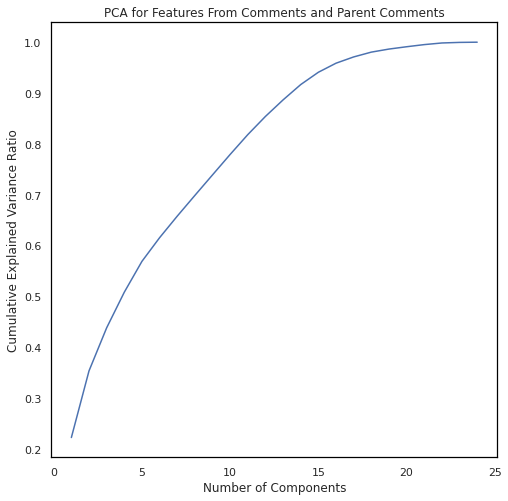

In [ ]:
# PCA
pca = PCA(n_components=24)
pca.fit_transform(full_x_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

# Plot results
sns.set(rc = {'figure.figsize':(8, 8)})
plt.plot(range(1, 25), cum_evr)
pca_ax = plt.axes()
pca_ax.set_facecolor("white")
pca_ax.spines["left"].set_color("black")
pca_ax.spines["bottom"].set_color("black")
pca_ax.spines["right"].set_color("black")
pca_ax.spines["top"].set_color("black")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA for Features From Comments and Parent Comments")

In [ ]:
# Adjust PCA appropriately and retry regression
pca = PCA(n_components=22) 
full_x_train_pca = pca.fit_transform(full_x_train_scaled)
full_x_test_pca = pca.transform(full_x_test_trans)

logr = LogisticRegression(solver='saga', max_iter=100, tol=1e-2, penalty='none', random_state=42)
logr.fit(full_x_train_pca, full_y_train)
logr.predict(full_x_test_pca)
train_accuracy = logr.score(full_x_train_pca, full_y_train)
test_accuracy = logr.score(full_x_test_pca, full_y_test)
print('Training Accuracy: ' + str(train_accuracy))
print('Test Accuracy: ' + str(test_accuracy))

Training Accuracy: 0.5411516933830313
Test Accuracy: 0.5392149588187282


In [ ]:
# And now PCA and regularization on all extracted features
def fulllogrWithReg(pvalues, cvalues):
  train_accuracies = []
  test_accuracies = []
  for pval in pvalues:
    for cval in cvalues:
      logr = LogisticRegression(solver='saga', max_iter=100, penalty='elasticnet', tol=1e-2, l1_ratio=pval, C=cval)
      logr.fit(full_x_train_pca, full_y_train)
      logr.predict(full_x_test_pca)
      train_acc = logr.score(full_x_train_pca, full_y_train)
      test_acc = logr.score(full_x_test_pca, full_y_test)
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)
      print('Accuracies for model with elasticnet param = ' + str(pval) + ', l1 strength = ' + str(cval) + ':')
      print('Training: ' + str(train_acc))
      print('Testing: '  +str(test_acc))
  return train_accuracies, test_accuracies

regStrength = [0.01, 0.1, 0.3, 0.6, 0.9, 0.99]
elasticStrength = [0.01, 0.1, 0.3, 0.6, 0.9, 0.99]
fullregModTrainAcc, fullregModTestAcc = fulllogrWithReg(elasticStrength, regStrength)

Accuracies for model with elasticnet param = 0.01, l1 strength = 0.01:
Training: 0.5411009895896456
Testing: 0.5392644258118771
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.1:
Training: 0.5411133563685201
Testing: 0.5393039994063961
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.3:
Training: 0.5410948062002082
Testing: 0.5392594791125621
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.6:
Training: 0.5411417999599316
Testing: 0.5392891593084514
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.9:
Training: 0.5411405632820442
Testing: 0.5391753852242092
Accuracies for model with elasticnet param = 0.01, l1 strength = 0.99:
Training: 0.5411356165704944
Testing: 0.5392446390146175
Accuracies for model with elasticnet param = 0.1, l1 strength = 0.01:
Training: 0.5411294331810571
Testing: 0.5392149588187282
Accuracies for model with elasticnet param = 0.1, l1 strength = 0.1:
Training: 0.5410910961665459
Testing: 0.

As these results show, including information from parent comments does improve the accuracy, albeit again only by a very small amount. Again, PCA and regularization helps with the best model in terms of testing accuracy having elasticnet parameter = 0.6 and regularization strength = 0.1 and producing training accuracy 0.54138 and testing accuracy 0.53935. Our conclusion is that a simple logistic regression model can only achieve so much accuracy when trained on basic text features.

However, before moving on to BERT and contextual embeddings, we can attempt analysis with the same features with a random forest model. Random forests are typically better than simple logistic regression and may give a better idea of the usefulness of our extracted features. 

In [ ]:
# Build and test with random forest classifier, tuning for the number of estimators and the maximum depth
from sklearn.ensemble import RandomForestClassifier

def rndmForestModel(estimators, depth):
  train_accuracy = []
  test_accuracy = []
  for n in estimators:
    for d in depth:
      rndmforest = RandomForestClassifier(n_estimators=n, max_depth=d)
      rndmforest.fit(full_x_train_pca, full_y_train)
      rndmforest.predict(full_x_test_pca)
      rf_train_acc = rndmforest.score(full_x_train_pca, full_y_train)
      rf_test_acc = rndmforest.score(full_x_test_pca, full_y_test)
      train_accuracy.append(rf_test_acc)
      test_accuracy.append(rf_test_acc)
      print('Accuracies for model with ' + str(n) + ' estimators and depth ' + str(d) + ':')
      print('Training: ' + str(rf_train_acc))
      print('Testing: '  + str(rf_test_acc))
  return train_accuracy, test_accuracy

estimator_list = [20, 50, 100, 500]
depth_list = [2, 5, 10, 20]
rfModTrainAcc, rfModTestAcc = rndmForestModel(estimator_list, depth_list)

Accuracies for model with 20 estimators and depth 2:
Training: 0.540626105280862
Testing: 0.5399915906111648
Accuracies for model with 20 estimators and depth 5:
Training: 0.5810704189122676
Testing: 0.5782493631124632
Accuracies for model with 20 estimators and depth 10:
Training: 0.6038129252626085
Testing: 0.5904034033291287
Accuracies for model with 20 estimators and depth 20:
Training: 0.8019089359870792
Testing: 0.5884049368059162
Accuracies for model with 50 estimators and depth 2:
Training: 0.550601149121093
Testing: 0.5501718978011921
Accuracies for model with 50 estimators and depth 5:
Training: 0.5799487520683437
Testing: 0.5782691499097228
Accuracies for model with 50 estimators and depth 10:
Training: 0.6042964663166044
Testing: 0.5910167940441741
Accuracies for model with 50 estimators and depth 20:
Training: 0.8255072234355406
Testing: 0.5942173085009028
Accuracies for model with 100 estimators and depth 2:
Training: 0.5454256521620839
Testing: 0.5441567114342954
Accurac

These results show that a good random forest model for this problem has at least 100 estimators and a max depth of about 10. At greater depths the model begins to demonstrate overfitting for all numbers of estimators tested where the training accuracy sees a large increase while testing accuracy remains about the same. Increasing the number of estimators above 100 only adds a fraction of a percent in terms of testing accuracy. The most optimum parameters observed here are for a model with the most estimators tested (500) and a max depth of 10. This model gives training accuracy 0.60552 and testing accuracy 0.592. 

The random forest model achieves a relatively large increase in accuracy compared to all cases of simple logistic regression tested above. We therefore conclude it is a better model.

We will now try sarcasm prediction using different forms of feature extraction, starting with a TF-IDF model.

In [ ]:
# Build and test a Tfidf model, tuning for the minimum and maximum document frequency cutoff when building the vocabulary as well as the ngram size to sample.
# Combine the Tfidf vectorizer with a logistic regression classifier using the same parameters as above minus the regularization as we now are working with different features.

X_train_tf ,X_test_tf ,Y_train_tf ,Y_test_tf = train_test_split(sarc_data_df['comment'].astype(str), sarc_data_df['label'], random_state=100)
def tfidfModel(ngrams):
  train_accuracy = []
  test_accuracy = []
  for ngram in ngrams:
    lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=ngram)), ('clf',  LogisticRegression(solver='saga', max_iter=100, tol=1e-2, random_state= 42))])
    lr_clf.fit(X_train_tf, Y_train_tf)
    lr_clf.predict(X_test_tf)
    tf_train_acc = lr_clf.score(X_train_tf, Y_train_tf)
    tf_test_acc = lr_clf.score(X_test_tf,Y_test_tf) 
    train_accuracy.append(tf_train_acc)
    test_accuracy.append(tf_test_acc)
    print('Accuracies for model using ngrams ' + str(ngram) + ':' )
    print('Training: ' + str(tf_train_acc))
    print('Testing: '  +str(tf_test_acc))
  return train_accuracy, test_accuracy

ngrams = [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)]
tfModTrainAcc, tfModTestAcc = tfidfModel(ngrams)

Accuracies for model using ngrams (1, 1):
Training: 0.7260404258659058
Testing: 0.6952400927604138
Accuracies for model using ngrams (1, 2):
Training: 0.817236725987661
Testing: 0.7245443105099448
Accuracies for model using ngrams (2, 2):
Training: 0.8464038708366806
Testing: 0.7025334990146185
Accuracies for model using ngrams (1, 3):
Training: 0.8499417606872107
Testing: 0.7244572486881367
Accuracies for model using ngrams (2, 3):
Training: 0.8854275082148431
Testing: 0.7042193324732681
Accuracies for model using ngrams (3, 3):
Training: 0.9227138596373201
Testing: 0.6544753733764949


With the TF-IDF model, using longer n-grams increases training accuracy but decreases testing accuracy, suggesting overfitting. The most accuracy is achieved for the test case when using just n-grams of length 1 and 2 (training accuracy = 0.8172, test accuracy = 0.7245). In all cases, this model performs better than any of the previous.

# BERT Analysis

Attached in seperate workbook (training takes multiple hours per model, was cumbersome to combine).

# Comparison of Models

In terms of testing accuracy achieved, BERT performs best, followed by the TF-IDF model, followed by the random forest model trained on basic text features, followed by the simple logistic regression models trained on basic text features. 

# Challenges/Limitations Faced



*   The large dataset in combination with alogorithms such as BERT meant long run times for several parts of the analyses. 
*   The dataset lacked some annotation so columns such as the "score", "ups", and "downs" column were unusable. 
*   Deciding what types of features to extract and how many for the simple logistic regression models will always be a process that comes with some uncertainty. We are sure we can create a model that achieves greater accuracy if we were to continue extracting different kinds of basic features.
*   The dataset labels for sarcasm were determined by if a reddit comment had the /s tag which means it depends on users' appropriately labeling their comments which may not always be happen. 







# Potential Next Steps



*   Perhaps combining the contextual embeddings found with BERT along with other features such as TF-IDF features or even the basic text features extracted here could make for a better model.
*   We focused on just the text of comments and parent comments in developing these models, but there are some other features available such as the time the comment was made and the subreddit that could potentially be useful. 
*   Cross-validation with tools such as GridSearchCV in scikit-learn would be possible given that this is a large dataset and could help optimize models. 

